<a id='main' name="main"></a>
# Vital Data Analysis

Date: 2022.10.17 
Author: © 2022 Anonymous course participant

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

In this work we answer the questions:
1. [During which hours and weekdays do most road traffic accidents occur in NYC that cause casualties (injuries/deaths)?](#Q1)
2. [Are there any meteorological indicators that correlate with the amount of road traffic accidents in NYC that cause casualties during certain points in time?](#Q2)
3. [Is it possible to accurately predict whether or not a road traffic accident in NYC will have casualties based on the date, time, geographic coordinates and meteorological data?](#Q3)

Using the open data from: 
* [Kaggle dataset](https://www.kaggle.com/datasets/) road traffic accident in NYC data from <https://www.kaggle.com/datasets/pavetr/nypdcollisions>
* [Ohio State University Environmental Mesonet Archive](https://mesonet.agron.iastate.edu/) meteorological data from <https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS>

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

#### 1. The road traffic accidents dataset 

In [ ]:
%pip install ipykernel pandas numpy matplotlib scikit-learn seaborn imbalanced-learn

import pandas as pd
import numpy as np
from os.path import exists
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier

## Load the data

##### Load up the datasets in Pandas as pickles (convert it to pickles if needed)

Since the dataset takes awhile to load, it has been chosen to convert it to the pickle format for faster loading times. This conversion to the pickle format happens only once, later the dataset is loaded only using this format.

In [12]:
vehicle_collisions_dataset_pickle_path = 'res/vehicle_collisions.pickle'
weather_dataset_pickle_path = 'res/weather.pickle'
for pickle_path in [vehicle_collisions_dataset_pickle_path, weather_dataset_pickle_path]:
  if not exists(pickle_path):
    pd.read_csv(pickle_path.replace('.pickle', '.csv')).to_pickle(pickle_path, protocol=4)
df_vehicle_collisions = pd.read_pickle(vehicle_collisions_dataset_pickle_path)
df_weather = pd.read_pickle(weather_dataset_pickle_path)

---

Road traffic accident dataset

In [13]:
df_vehicle_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089265 entries, 0 to 1089264
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   DATE                           1089265 non-null  object 
 1   TIME                           1089265 non-null  object 
 2   BOROUGH                        792241 non-null   object 
 3   ZIP CODE                       792171 non-null   object 
 4   LATITUDE                       882199 non-null   float64
 5   LONGITUDE                      882199 non-null   float64
 6   LOCATION                       882199 non-null   object 
 7   ON STREET NAME                 892128 non-null   object 
 8   CROSS STREET NAME              854727 non-null   object 
 9   OFF STREET NAME                160587 non-null   object 
 10  NUMBER OF PERSONS INJURED      1089265 non-null  int64  
 11  NUMBER OF PERSONS KILLED       1089265 non-null  int64  
 12  NUMBER OF PEDE

The columns are explained [here](https://www.kaggle.com/datasets/pavetr/nypdcollisions).

---

Weather dataset

In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55234 entries, 0 to 55233
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station            55234 non-null  object 
 1   valid              55234 non-null  object 
 2   tmpf               55196 non-null  float64
 3   dwpf               55193 non-null  float64
 4   relh               55185 non-null  float64
 5   drct               33737 non-null  float64
 6   sknt               51776 non-null  float64
 7   p01i               48412 non-null  float64
 8   alti               54677 non-null  float64
 9   mslp               44342 non-null  float64
 10  vsby               54317 non-null  float64
 11  gust               9409 non-null   float64
 12  skyc1              54561 non-null  object 
 13  skyc2              12087 non-null  object 
 14  skyc3              4624 non-null   object 
 15  skyc4              0 non-null      float64
 16  skyl1              314

The columns are explained [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS).

[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. During which hours and weekdays do most road traffic accidents occur in NYC that cause casualties (injuries/deaths)? 

---

##### Before answering the question, we have to perform some data pre-processing:
* Leave only the columns necessary for the tasks;
* Drop rows that do not have coordinates of where the accident occured;
* Convert the date and time columns to a datetime index;
* Sort the dataset by the new index;
* Convert column names to snake-case.
* Engineer a feature for whether if a person was killed or injured
* Engineer lag features for the target variable (casualty)

In [15]:
# Filter rows.
df_vehicle_collisions_filtered_rows = df_vehicle_collisions[[
  'DATE',
  'TIME',
  'LATITUDE',
  'LONGITUDE',
  'NUMBER OF PERSONS KILLED',
  'NUMBER OF PERSONS INJURED',
]]

# Drop rows that do not have latitude or longitude.
df_vehicle_collisions_filtered_rows = df_vehicle_collisions_filtered_rows.dropna(subset=['LATITUDE', 'LONGITUDE'], how='any').reset_index(drop=True)

# Create a datetime feature.
df_vehicle_collisions_filtered_rows['DATE_TIME'] = pd.to_datetime(
  df_vehicle_collisions_filtered_rows['DATE'] + df_vehicle_collisions_filtered_rows['TIME'],
  format='%m/%d/%Y%H:%M')

# Create a casualty feature where it is 1 if a person has been injured/killed, 0 otherwise.
df_vehicle_collisions_filtered_rows['casualty'] = np.select([
  (df_vehicle_collisions_filtered_rows['NUMBER OF PERSONS KILLED'] > 0) | (df_vehicle_collisions_filtered_rows['NUMBER OF PERSONS INJURED'] > 0),
  (df_vehicle_collisions_filtered_rows['NUMBER OF PERSONS KILLED'] == 0) & (df_vehicle_collisions_filtered_rows['NUMBER OF PERSONS INJURED'] == 0)],
  [1, 0])

# Drop unneeded columns, set index to the created datetime feature, convert the leftover column names to snake case.
df_vehicle_collisions_filtered_rows = df_vehicle_collisions_filtered_rows.drop(columns=['DATE', 'TIME', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']).sort_values(by=['DATE_TIME']).set_index('DATE_TIME')
df_vehicle_collisions_filtered_rows.columns = [x.lower().replace(' ', '_') for x in df_vehicle_collisions_filtered_rows.columns]
df_vehicle_collisions_filtered_rows.index.names = ['datetime']

# Sort the dataframe by datetime, then casualty. After this, remove rows with duplicate indeces.
df_vehicle_collisions_filtered_rows = df_vehicle_collisions_filtered_rows.sort_values(['datetime', 'casualty'])[~df_vehicle_collisions_filtered_rows.index.duplicated(keep='last')]

# Add lag values.
for lag in range(1, 4):
  df_vehicle_collisions_filtered_rows['casualty_' + str(lag)] = df_vehicle_collisions_filtered_rows.casualty.shift(lag)
df_vehicle_collisions_filtered_rows.dropna(axis=0, how='any', inplace=True)

df_vehicle_collisions_filtered_rows

,latitude,longitude,casualty,casualty_1,casualty_2,casualty_3
datetime,,,,,,
2012-07-01 00:22:00,40.824188,-73.913840,0,0.0,1.0,1.0
2012-07-01 00:23:00,40.607179,-73.916414,0,0.0,0.0,1.0
2012-07-01 00:25:00,40.732979,-73.844348,0,0.0,0.0,0.0
2012-07-01 00:30:00,40.714678,-74.005887,1,0.0,0.0,0.0
2012-07-01 00:37:00,40.755924,-73.974889,1,1.0,0.0,0.0
...,...,...,...,...,...,...
2017-08-04 23:30:00,40.699825,-73.886770,1,1.0,0.0,1.0
2017-08-04 23:35:00,40.772068,-73.920080,0,1.0,1.0,0.0
2017-08-04 23:40:00,40.691643,-73.820050,0,0.0,1.0,1.0


The dataset is now more condensed, including only the features that we need for our tasks. It was chosen to encode the casualties in a binary format because casualties (injuries/deaths) are about twice as rare compared to road traffic accidents that do not have casualties (see figure below), so classifying whether or not they will happen is already a task involving a imbalanced target feature. Classifying them in a more detailed way (e.g. cyclist injury, car driver death) would be a more challenging task.

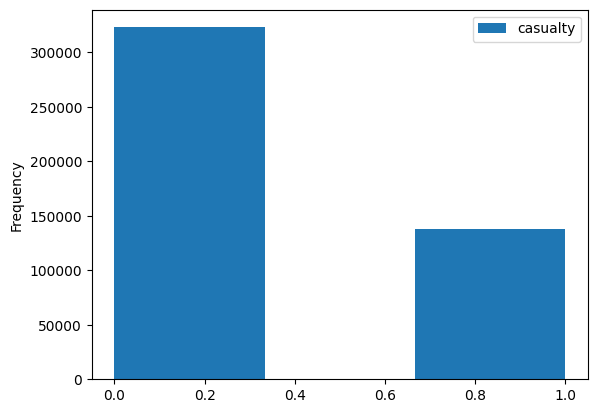

In [16]:
df_vehicle_collisions_filtered_rows.plot.hist(column=['casualty'], bins=3, range=[0, 1])
plt.show()

##### Add additional features based on datetime index

Since the datetime index is available, it can be used to generate various features that could prove useful to our models. A **is_winter** feature has been chosen based on the more dangerous road conditions during this season in this specific city.

In [17]:
df_vehicle_collisions_engineered_rows = df_vehicle_collisions_filtered_rows.copy()
df_vehicle_collisions_engineered_rows['hour'] = df_vehicle_collisions_engineered_rows.index.hour
df_vehicle_collisions_engineered_rows['weekday'] = df_vehicle_collisions_engineered_rows.index.weekday
df_vehicle_collisions_engineered_rows['is_winter'] = np.where(df_vehicle_collisions_engineered_rows.index.month % 12 // 3 + 1 == 1, 1, 0)
df_vehicle_collisions_engineered_rows

,latitude,longitude,casualty,casualty_1,casualty_2,casualty_3,hour,weekday,is_winter
datetime,,,,,,,,,
2012-07-01 00:22:00,40.824188,-73.913840,0,0.0,1.0,1.0,0,6,0
2012-07-01 00:23:00,40.607179,-73.916414,0,0.0,0.0,1.0,0,6,0
2012-07-01 00:25:00,40.732979,-73.844348,0,0.0,0.0,0.0,0,6,0
2012-07-01 00:30:00,40.714678,-74.005887,1,0.0,0.0,0.0,0,6,0
2012-07-01 00:37:00,40.755924,-73.974889,1,1.0,0.0,0.0,0,6,0
...,...,...,...,...,...,...,...,...,...
2017-08-04 23:30:00,40.699825,-73.886770,1,1.0,0.0,1.0,23,4,0
2017-08-04 23:35:00,40.772068,-73.920080,0,1.0,1.0,0.0,23,4,0
2017-08-04 23:40:00,40.691643,-73.820050,0,0.0,1.0,1.0,23,4,0


##### Find out during which hours and weekdays do most fatal road traffic accidents occur

In [18]:
collisions_during_hours = df_vehicle_collisions_engineered_rows[['hour', 'casualty']].groupby(['hour']).sum().sort_values(by='casualty', ascending=False)
collisions_during_hours

,casualty
hour,
17,9316
18,9057
16,8981
14,8094
15,8039
19,7829
20,7210
13,7071
8,7056


It can be observed that most accidents happen during the evening hours, whilst relatively few accidents happen during the midnight/early morning hours.

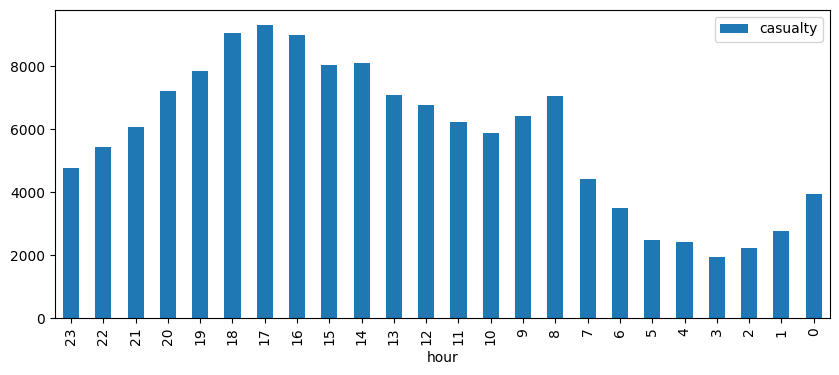

In [19]:
collisions_during_hours.sort_values(by=['hour'], ascending=False).plot(kind='bar', figsize=(10, 4))
plt.show()

In [20]:
collisions_during_weekdays = df_vehicle_collisions_engineered_rows[['weekday', 'casualty']].groupby(['weekday']).sum().sort_values(by='casualty', ascending=False)
collisions_during_weekdays

,casualty
weekday,
4,21372
2,20031
3,20021
1,19980
0,19576
5,19084
6,17786


There does not seem to be any week day that has significantly more casualties, although sligthly more tend to occur during friday (index 4). This can be due to the after-work rush hours.

To answer this question, most traffic accidents happen during the evening hours and on fridays.

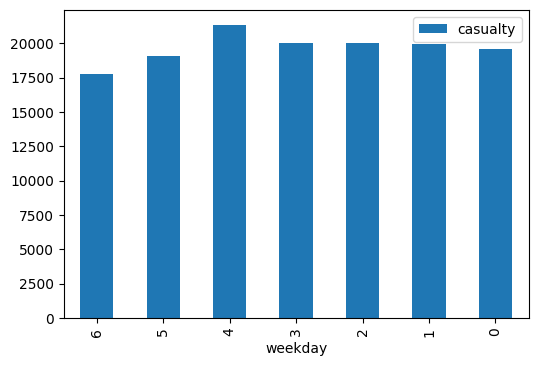

In [21]:
collisions_during_weekdays.sort_values(by=['weekday'], ascending=False).plot(kind='bar', figsize=(6, 4))
plt.show()

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. Are there any meteorological indicators that correlate with the amount of road traffic accidents in NYC that cause casualties during certain points in time? 

##### Before answering this question, the dataset has to be pre-processed in the following ways:

* Drop unnecessary columns, resample the datetime indeces according to the indices of the road traffic incidents dataset
* Replace NaN values with 0 (if any exist)

In [22]:
df_weather_filtered = df_weather.drop(
  [
    'station', \
    'wxcodes', \
    'metar', \
    'skyc1', \
    'skyc2', \
    'skyc3', \
    'skyc4', \
    'skyl1', \
    'skyl2', \
    'skyl3', \
    'skyl4', \
    'ice_accretion_1hr', \
    'ice_accretion_3hr', \
    'ice_accretion_6hr', \
    'peak_wind_gust', \
    'peak_wind_drct', \
    'peak_wind_time', \
    'snowdepth', \
    'mslp', \
    'drct', \
    'sknt', \
    'dwpf', \
    'feel', \
  ],
  axis = 1
)

# Convert datatime feature to a Pandas datetime, assign it to the dataframe.
datetime_series = pd.to_datetime(df_weather_filtered['valid'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df_weather_filtered.set_index(datetime_index, inplace=True)
datetime_index = df_weather_filtered.index.tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)
df_weather_filtered.set_index(datetime_index, inplace=True)

# Remove rows with duplicate indeces.
df_weather_filtered = df_weather_filtered[~df_weather_filtered.index.duplicated(keep='first')]

# Fill NaN values with 0.0, reindex the weather dataframe based on the traffic accident dataframe's indeces.
df_weather_filtered.fillna(0.0, inplace=True)
df_weather_filtered = df_weather_filtered.reindex(df_vehicle_collisions_engineered_rows.index, method='ffill')

# Drop the datetime feature, rename columns to more human-friendly names.
df_weather_filtered.drop(columns=['valid'], inplace=True)
df_weather_filtered.rename(columns={
  "tmpf": "temperature",
  "relh": "relative_humidity",
  "p01i": "precipitation",
  "alti": "relative_humidity",
  "gust": "wind_gust_speed",
  "vsby": "visibility",
  }, inplace=True)
df_weather_filtered

,temperature,relative_humidity,precipitation,relative_humidity,visibility,wind_gust_speed
datetime,,,,,,
2012-07-01 00:22:00,77.0,59.98,0.0,29.82,10.0,0.0
2012-07-01 00:23:00,77.0,59.98,0.0,29.82,10.0,0.0
2012-07-01 00:25:00,77.0,59.98,0.0,29.82,10.0,0.0
2012-07-01 00:30:00,77.0,59.98,0.0,29.82,10.0,0.0
2012-07-01 00:37:00,77.0,59.98,0.0,29.82,10.0,0.0
...,...,...,...,...,...,...
2017-08-04 23:30:00,75.0,87.68,0.0,29.90,10.0,0.0
2017-08-04 23:35:00,75.0,87.68,0.0,29.90,10.0,0.0
2017-08-04 23:40:00,75.0,87.68,0.0,29.90,10.0,0.0


Once the dataset is pre-processed, we can merge it with the road traffic incidents dataset.

In [23]:
df = pd.merge(
    df_weather_filtered,
    df_vehicle_collisions_engineered_rows,
    left_index = True,
    right_index = True,
    how = 'inner' \
).apply(pd.to_numeric)
df

,temperature,relative_humidity,precipitation,relative_humidity,visibility,wind_gust_speed,latitude,longitude,casualty,casualty_1,casualty_2,casualty_3,hour,weekday,is_winter
datetime,,,,,,,,,,,,,,,
2012-07-01 00:22:00,77.0,59.98,0.0,29.82,10.0,0.0,40.824188,-73.913840,0,0.0,1.0,1.0,0,6,0
2012-07-01 00:23:00,77.0,59.98,0.0,29.82,10.0,0.0,40.607179,-73.916414,0,0.0,0.0,1.0,0,6,0
2012-07-01 00:25:00,77.0,59.98,0.0,29.82,10.0,0.0,40.732979,-73.844348,0,0.0,0.0,0.0,0,6,0
2012-07-01 00:30:00,77.0,59.98,0.0,29.82,10.0,0.0,40.714678,-74.005887,1,0.0,0.0,0.0,0,6,0
2012-07-01 00:37:00,77.0,59.98,0.0,29.82,10.0,0.0,40.755924,-73.974889,1,1.0,0.0,0.0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-04 23:30:00,75.0,87.68,0.0,29.90,10.0,0.0,40.699825,-73.886770,1,1.0,0.0,1.0,23,4,0
2017-08-04 23:35:00,75.0,87.68,0.0,29.90,10.0,0.0,40.772068,-73.920080,0,1.0,1.0,0.0,23,4,0
2017-08-04 23:40:00,75.0,87.68,0.0,29.90,10.0,0.0,40.691643,-73.820050,0,0.0,1.0,1.0,23,4,0


Having all of the features in-place, we can calculate the Pearson's correlation coefficient for all feature-pairs and plot the matrix.

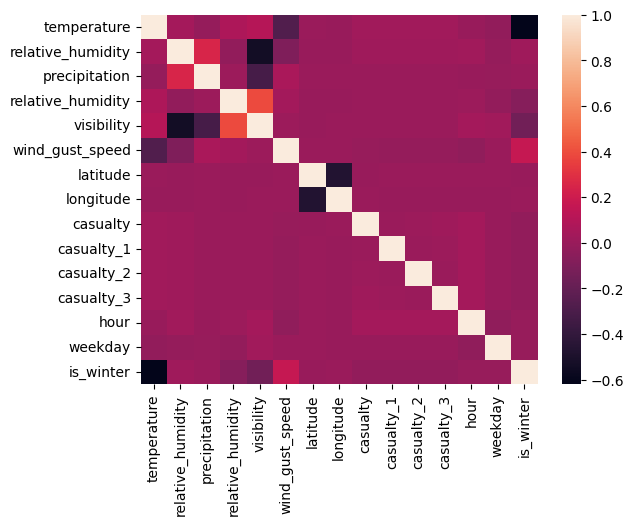

In [24]:
sns.heatmap(df.corr())
plt.show()

There does not seem to be any features that significantly correlate with the casualty feature, although that does not necessarily mean that all other features are irrelevant for performing predictions.

Based on the correlation matrix we can also answer the question by stating that there does not seem to be any meteorological value that correlates with whether or a casualty has happened in a certain point in time. 

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. Is it possible to accurately predict whether or not a road traffic accident in NYC will have casualties based on the date, time, geographic coordinates and meteorological data? 

To answer this question, it was chosen to use perform a classification task for the *casualty* feature.

The dataset was split into a train/test split based on the datetime index. It was chosen to leave the last 25% of the values for testing.

In [25]:
tss = TimeSeriesSplit(n_splits=2, test_size=round(len(df.values) * 0.25))
train_splits, test_splits = tss.split(df)
train_df = df.iloc[train_splits[1], :]
test_df = df.iloc[test_splits[1], :]
X_train = train_df.drop(['casualty'], axis=1)
y_train = train_df[['casualty']]
X_test = test_df.drop(['casualty'], axis=1)
y_test = test_df[['casualty']]

For the algorithm it was chosen to use a balanced Random forest. A balanced variation of the model was used due to it being more robust to imbalanced datasets. This modification performs additional pre-processing steps to the dataset before passing the data to the Random forest algorithm.

Random forest was chosen because it is one of the more advanced and robust models for classification tasks, and because it does not take a relatively long time to train compared to more computationally complicated algorithms like Multi-layer perceptrons or Deep neural networks.

In [26]:
rf = BalancedRandomForestClassifier(
  min_samples_leaf=2,
  min_samples_split=3,
  n_estimators=100,
  random_state=1,
  n_jobs=-1).fit(X_train, y_train.values.ravel())

For the error metrics, accuracy score and balanced accuracy score was used. Accuracy score can is a common metric for evaluating the accuracy of predictions in classification tasks, whilst the balanced accuracy score is adjusted to be used for imbalanced datasets. 

Acc. score: 0.7318583634884902
Balanced acc. score: 0.7361432930482139


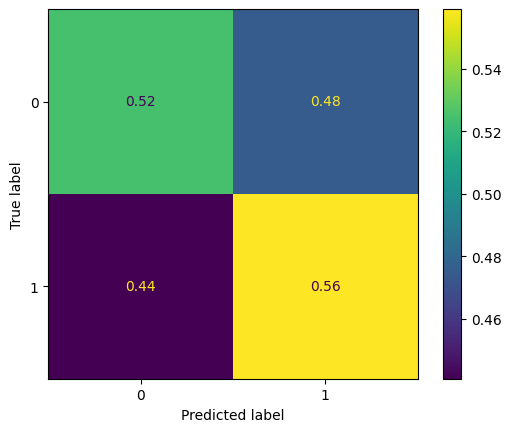

In [27]:
y_pred = rf.predict(X_test)

print('Acc. score: {}\nBalanced acc. score: {}'.format(
  np.sqrt(accuracy_score(y_test, y_pred)),
  np.sqrt(balanced_accuracy_score(y_test, y_pred))))
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

It can be observed that the RF model predicts casualties with a accuracy of 73%, although the true-positive predictions (which are of most interest) are around 56%.

In summary, this model can be used for predicting when casualties will occur with a accuracy of 56%, although true-negative predictions do occur at around 44% of the time.

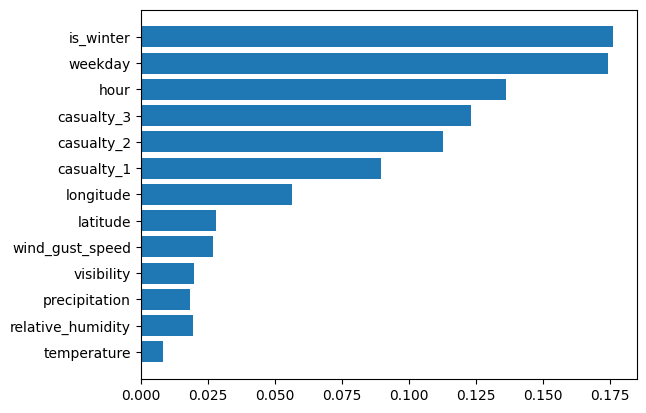

In [28]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns, rf.feature_importances_[sorted_idx])
plt.show()

When it comes to the most important features based on the Gini impurity, datetime index-based features seem to be the most important, whilst meteorological features are least important. It is also worth noting that the engineered lag features rank rather high compared to most features.

To answer this question, it can be stated that it is possible to predict whether or not a road traffic accident in NYC will have casualties (injuries/death) based on the date, time, geographic coordinates and meteorological data with a accuracy of 73%, although true-negative predictions can occur 44% of the time.